In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")
import pandas as pd
import numpy as np

from matplotlib import style
import seaborn as sns

from src.evaluate_model import report_metrics, weighted_absolute_percentage_error, r2_score_adjusted
from src.regression_model import MMMRegression
from sklearn.linear_model import Ridge
from src.utils.plots import plot_prediction, plot_weights
from src.optimize_hyperparams import optimize_linear_regression

pd.options.display.float_format = '{:.4f}'.format
sns.set_theme()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option("display.max_columns", 6)

sns.set_theme()

/Users/marianebando/Library/Caches/pypoetry/virtualenvs/projeto-ifood-aSl-TPdR-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problema Case Ifood
> Objetivo: Entender o impacto dos investimentos em mídia nos indicadores de desempenho (tráfego e engajamento do usuário) e fornecer recomendações estratégicas para otimizar o gasto com mídia.


> Desafio: Identificar quais canais de mídia estão impulsionando os KPIs e como otimizar o orçamento de mídia.

## Import data

De acordo com as instruções do case, as colunas do arquivo representam:
- mo­no­to­ni­cid: Iden­ti­fi­ca­dor úni­co para cada re­gis­tro.
- date: Data do re­gis­tro.
- traf­fic: Nú­me­ro de vi­si­tas ao site.
- no­ti­fi­ca­ti­ons­sent: Nú­me­ro de no­ti­fi­ca­ções en­vi­a­das.
- no­ti­fi­ca­ti­ons­clic­ked: Nú­me­ro de no­ti­fi­ca­ções que fo­ram cli­ca­das.
- nac­ti­veu­sers: Nú­me­ro de usuá­ri­os ati­vos.
- event1 e event2: in­di­ca­dor bo­o­le­a­no, re­la­ci­o­na­das ao acon­te­ci­men­to de eventos es­pe­cí­fi­cos.
- Co­lu­nas de in­ves­ti­men­to em mí­dia: cine­ma, digi­tal, in­flu, news­pa­pers, of­fli­ne, ra­dio, so­ci­al, tv, other­me­di­as.
- ho­li­day: In­di­ca­dor se o dia é fe­ri­a­do. 

In [2]:
medias = ["cinema","digital","influ","newpapers","offline","radio","social","tv","other_medias"]
medias_with_more_investment = ["tv", "other_medias", "digital", "offline", "influ", "social"]

In [3]:
from src.prepare_data import load_data, agg_by_week
df = load_data('/Users/marianebando/Documents/Git/projeto_ifood')
df_week = agg_by_week(df)
df_week.head()

,weeks_from_start,date,traffic,...,month,week_of_month,has_media_investment
0,1,2007-01-15,567597,...,2007-01,3,False
1,2,2007-01-22,560370,...,2007-01,4,False
2,3,2007-01-29,568526,...,2007-01,5,False
3,4,2007-02-05,600621,...,2007-02,5,False
4,5,2007-02-12,597438,...,2007-02,3,False


In [4]:
from src.utils.seasonality_effect import get_seasonality
degree = 2
period_year = 52

df_season_year = get_seasonality(df_week["date"], period = period_year, degree = degree)
df_season_year.columns = ["year_" + col for col in df_season_year.columns]
df_week = pd.concat([df_week, df_season_year], axis =1)

In [5]:
df_train, df_test = train_test_split(df_week, test_size = 0.20, random_state = 42, shuffle=False) # shuffle False to keep the order
print(f"Train set from week {int(df_train.index.min())} to {int(df_train.index.max())}")
print(f"Test set from week {int(df_test.index.min())} to {int(df_test.index.max())}")

Train set from week 0 to 52
Test set from week 53 to 66


# 1. StandardScale and Normalize Features

In [6]:
scale_features = ["notifications_sent"]
normalize_features = ["n_active_users", "holiday", "week_of_month"]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
norm = MinMaxScaler()
df_train[normalize_features] = norm.fit_transform(df_train[normalize_features])
df_test[normalize_features] = norm.transform(df_test[normalize_features])

scale = StandardScaler()
df_train[scale_features] = scale.fit_transform(df_train[scale_features])
df_test[scale_features] = scale.transform(df_test[scale_features])


# 2. Ridge

O Ridge Regression é frequentemente preferido à Regressão Linear em casos de multicolinearidade porque ele adiciona um termo de regularização que ajuda a estabilizar as estimativas dos coeficientes, tornando o modelo mais robusto. 


Na Regressão Linear sem regularização, a multicolinearidade pode causar coeficientes instáveis, ou seja, pequenas variações nos dados podem levar a grandes mudanças nos coeficientes estimados. Isso resulta em um modelo sensível ao ruído e com baixa capacidade de generalização.


Ao aplicar a penalidade, o Ridge controla o problema de multicolinearidade, produzindo coeficientes mais estáveis e menos sensíveis ao ruído nos dados. O modelo resultante tende a generalizar melhor para novos dados.

## 2.1 Ridge sem restrições

In [7]:
# use normal Ridge regression
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"] + df_season_year.columns.tolist()
ridge_with_no_constraints = Ridge(alpha = 1)
ridge_with_no_constraints.fit(df_train[all_features], df_train["traffic"])
pred_ridge_with_no_constraints = ridge_with_no_constraints.predict(df_test[all_features])
report_metrics(df_test["traffic"], pred_ridge_with_no_constraints)

Metric    Value
--------  ----------
mae       R$ 23.4mil
mape      3.2%
wape      3.2%
r2        38.4%


Sem as variáveis sazonais (série de fourier), o modelo tem métricas melhores. Possivelmente a sazonalidade está confundindo-o.

In [8]:
# use normal Ridge regression
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"]
ridge_with_no_constraints = Ridge(alpha = 1)
ridge_with_no_constraints.fit(df_train[all_features], df_train["traffic"])
pred_ridge_with_no_constraints = ridge_with_no_constraints.predict(df_test[all_features])
report_metrics(df_test["traffic"], pred_ridge_with_no_constraints)

Metric    Value
--------  ----------
mae       R$ 21.6mil
mape      2.9%
wape      3.0%
r2        47.1%


## 2.2 Ridge com restrições

### Teste da Ridge com efeitos simples: Adstock geométrico e Saturação logística: melhor

In [9]:
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"] 

best_params = {"regression__alpha":0.1}
ridge_model = MMMRegression(
    medias=medias_with_more_investment, 
    model_type="ridge",
    positive_features=medias_with_more_investment+["event1", "event2"], 
    # biased_features=["n_active_users"],
    # confounders=all_features,
    all_features = all_features,
    best_params=best_params, 
    )
ridge_model.fit(df_train[all_features], df_train["traffic"])

pred_ridge_train = ridge_model.predict(df_train[all_features])
pred_ridge_test = ridge_model.predict(df_test[all_features])

print("Test")
print(ridge_model.score(df_test["traffic"], pred_ridge_test))

Test
Metric    Value
--------  ----------
mae       R$ 25.5mil
mape      3.6%
wape      3.5%
r2        7.6%
None


No gráfico abaixo, é possível ver a diferença entre o dado "raw" e o dado com o adstock + sazonalidade - essa última força o intervalo entre 0 e 1.

<Axes: >

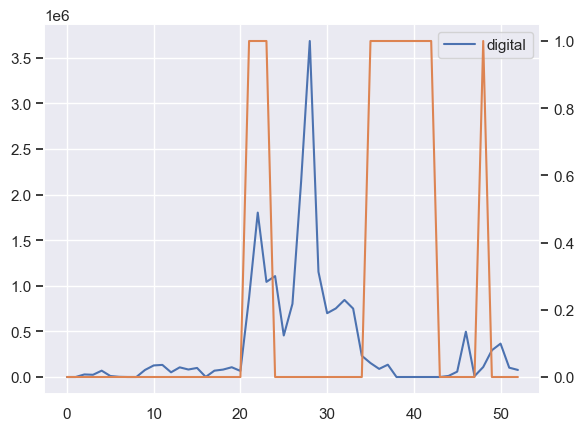

In [10]:
# apply adstock transformation to the media variables
df_train_transformed = ridge_model.model["adstock"].transform(df_train)
b = pd.DataFrame(df_train_transformed, columns=all_features)
# plot both original and transformed variable
df_train[["digital"]].plot(alpha = 1)
b["tv"].plot(secondary_y=True)

#### Otimizando Ridge

In [11]:
tuned_model = optimize_linear_regression(
    ridge_model.model, 
    X = df_train[all_features], 
    y = df_train["traffic"], 
    medias = medias_with_more_investment, 
    n_trials=500,
    scorer="r2", 
    # scorer=weighted_absolute_percentage_error,
    dump=True,
    dir = "/Users/marianebando/Documents/Git/projeto_ifood/models"
    )

[I 2024-08-16 15:12:38,744] A new study created in memory with name: no-name-dca354b3-4c38-4b50-b4f8-17d7aed2e70f
[I 2024-08-16 15:12:39,467] Trial 2 finished with value: -7.069631203823856 and parameters: {'adstock__tv_pipe__carryover__func': 'delayed', 'adstock__tv_pipe__carryover__decay_factor': 0.8084767109679853, 'adstock__tv_pipe__carryover__L': 7, 'adstock__tv_pipe__carryover__theta': 4, 'adstock__tv_pipe__saturation__function_curve': 'log', 'adstock__tv_pipe__saturation__midpoint': 1028237.6609928971, 'adstock__tv_pipe__saturation__c': 0.5232955042039713, 'adstock__tv_pipe__saturation__beta': 0.6816218181792346, 'adstock__tv_pipe__saturation__lambda_': 0.05274737678381399, 'regression__alpha': 0.46288776783240476, 'adstock__other_medias_pipe__carryover__func': 'delayed', 'adstock__other_medias_pipe__carryover__decay_factor': 0.7810929748555517, 'adstock__other_medias_pipe__carryover__L': 3, 'adstock__other_medias_pipe__carryover__theta': 4, 'adstock__other_medias_pipe__saturati

Melhores parâmetros encontrados:  {'adstock__tv_pipe__carryover__func': 'delayed', 'adstock__tv_pipe__carryover__decay_factor': 0.9263115877080307, 'adstock__tv_pipe__carryover__L': 2, 'adstock__tv_pipe__carryover__theta': 2, 'adstock__tv_pipe__saturation__function_curve': 'log', 'adstock__tv_pipe__saturation__midpoint': 1486106.0944972804, 'adstock__tv_pipe__saturation__c': 0.7616245805451638, 'adstock__tv_pipe__saturation__beta': 0.8683017855355705, 'adstock__tv_pipe__saturation__lambda_': 0.05394479908169395, 'regression__alpha': 0.031020431517811198, 'adstock__other_medias_pipe__carryover__func': 'delayed', 'adstock__other_medias_pipe__carryover__decay_factor': 0.8751779307409578, 'adstock__other_medias_pipe__carryover__L': 4, 'adstock__other_medias_pipe__carryover__theta': 2, 'adstock__other_medias_pipe__saturation__function_curve': 'hill', 'adstock__other_medias_pipe__saturation__midpoint': 1508937.2560287805, 'adstock__other_medias_pipe__saturation__c': 1.544521138890311, 'adsto

In [18]:
from glob import glob
import json
last_file = sorted(
    list(glob("/Users/marianebando/Documents/Git/projeto_ifood/models/hyperparams_calibration_*.json")), reverse=True
)[0]
with open(last_file, "r") as f:
    best_params = json.load(f)["best_params"]

In [20]:
assert best_params == best_params_simple

Train
Metric    Value
--------  ----------
mae       R$ 16.8mil
mape      2.6%
wape      2.6%
r2        78.6%
None
Test
Metric    Value
--------  ----------
mae       R$ 19.0mil
mape      2.6%
wape      2.6%
r2        49.2%
None


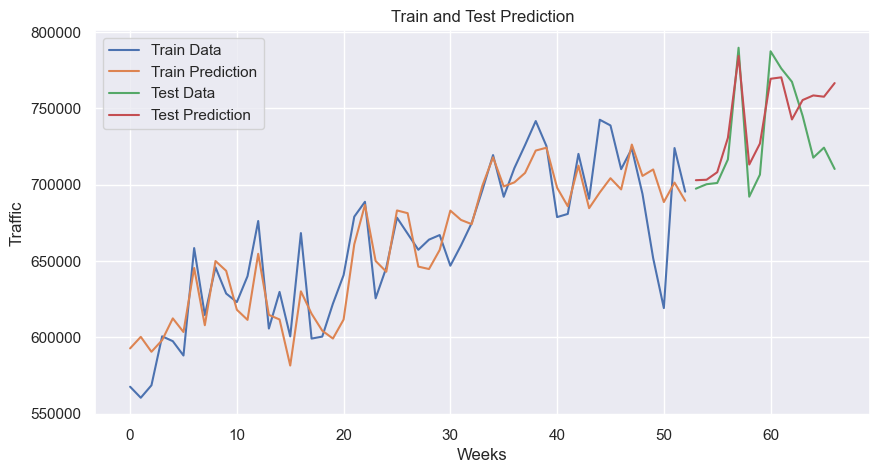

In [21]:
best_params_simple = tuned_model.best_params_

all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"] 
ridge_model = MMMRegression(
    medias=medias_with_more_investment, 
    model_type="ridge", 
    positive_features=medias_with_more_investment+["event1", "event2"], 
    all_features = all_features, 
    best_params=best_params_simple
    )
ridge_model.fit(df_train[all_features], df_train["traffic"])

pred_ridge_train = ridge_model.predict(df_train[all_features])
pred_ridge_test = ridge_model.predict(df_test[all_features])
print("Train")
print(ridge_model.score(df_train["traffic"], pred_ridge_train))
print("Test")   
print(ridge_model.score(df_test["traffic"], pred_ridge_test))

plot_prediction(df_train["traffic"], df_test["traffic"], pred_ridge_train, pred_ridge_test, fig_size=(10,5))

In [22]:
# get coefficients from ridge_model.model.named_steps["regression"].coef_
weights = {col: float(coef) for col, coef in zip(all_features, ridge_model.model.named_steps["regression"].coef_)}
weights = pd.Series(weights).sort_values(ascending=False)
weights

n_active_users       105337.9747
holiday               50871.9506
tv                    18107.5986
offline               12071.6041
influ                 11933.9689
notifications_sent    10984.4232
event1                 8594.1311
event2                    0.0000
other_medias             -0.0000
digital                  -0.0000
social                   -0.0000
week_of_month        -35667.1661
dtype: float64

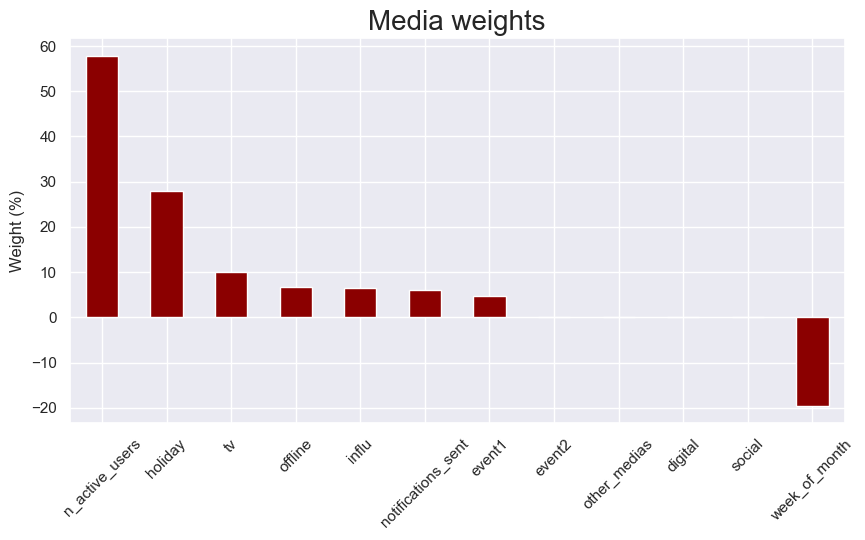

In [23]:
plot_weights(weights/weights.sum()*100, figsize=(10, 5))

In [38]:
# (weights/weights.sum())
weights["event1"]/df_week["traffic"].sum()*100

0.019011730429768413

In [28]:
(weights[medias_with_more_investment]/weights[medias_with_more_investment].sum()).sort_values(ascending=False)

tv              0.4300
offline         0.2866
influ           0.2834
other_medias   -0.0000
digital        -0.0000
social         -0.0000
dtype: float64